In [1]:
import pandas as pd
from tqdm.notebook import tqdm

from helpers.model import *
from helpers.utils import *

In [2]:
from transformers import AutoTokenizer, BertForMaskedLM
tokenizer = AutoTokenizer.from_pretrained('google/multiberts-seed_0-step_40k')
model = BertForMaskedLM.from_pretrained("google/multiberts-seed_0-step_40k")


Some weights of the model checkpoint at google/multiberts-seed_0-step_40k were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [3]:
# load the data
df = pd.read_csv('data_processed/niki.csv')

In [4]:
seed = 0

list_of_checkpoints = [f'google/multiberts-seed_{seed}-step_{i}k' for i in range(0, 200, 20)] + [f'google/multiberts-seed_{seed}-step_{i}k' for i in range(200, 2001, 100)]

In [5]:
df

,prompt,label1,label2,distractor1,distractor2,length,plural_match
0,The tourist hired the guides that the locals a...,guides,guides,tourist,tourist,short,mismatch
1,The tourists hired the guides that the locals ...,guides,guides,tourists,tourists,short,match
2,The tourist hired the guides that two days ago...,guides,guides,tourist,tourist,long,mismatch
3,The tourists hired the guides who two days ago...,guides,guides,tourists,tourists,long,match
4,The coach removed the gymnasts that the fans d...,gymnasts,gymnasts,coach,coach,short,mismatch
...,...,...,...,...,...,...,...
123,The editors censored the journalists that last...,journalists,journalists,editors,editors,long,match
124,The donor bored the researchers that interns d...,researchers,researchers,donor,donor,short,mismatch
125,The donors bored the researchers that interns ...,researchers,researchers,donors,donors,short,match
126,The donor bored the researchers that last year...,researchers,researchers,donor,donor,long,mismatch


In [10]:
from transformers import AutoTokenizer, BertForMaskedLM

accuracies = []
seed = 0
list_of_checkpoints = [f'google/multiberts-seed_{seed}-step_{i}k' for i in range(0, 200, 20)] + [f'google/multiberts-seed_{seed}-step_{i}k' for i in range(200, 2001, 100)]

for checkpoint in tqdm(list_of_checkpoints):
    # load the model and tokenizer
    tokenizer = AutoTokenizer.from_pretrained(checkpoint)
    model = BertForMaskedLM.from_pretrained(checkpoint)

    # initialize the model
    pt_model = Model(model, tokenizer)

    # predict the masked token
    step = checkpoint.split('_')[-1]
    pred_col = f'predicted_token{step}'
    top_prob_col = f'top_proba{step}'
    correct_col = f'correct{step}'

    # predict the masked token
    df[[pred_col,top_prob_col]] = df.apply(lambda row: pt_model.predict_masked_token(row), axis=1,result_type="expand")
    df[correct_col] = (df[pred_col] == df['label1']) | (df[pred_col] == df['label2'])

    # calculate the accuracy
    accuracy = np.array(df[correct_col]).mean()
    print(checkpoint, accuracy)
    accuracies.append(accuracy)


Some weights of the model checkpoint at google/multiberts-seed_0-step_0k were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


ValueError: Columns must be same length as key

In [7]:
# plot the accuracy by checkpoint
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")
ax = sns.barplot(x=list_of_checkpoints, y=accuracies)
plt.xticks(rotation=90)
plt.show()

/opt/anaconda3/envs/jupyter_39/lib/python3.9/site-packages/seaborn/categorical.py:638: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  vals = pd.Series(vals, index=index)


KeyError: 'google/multiberts-seed_0-step_0k'

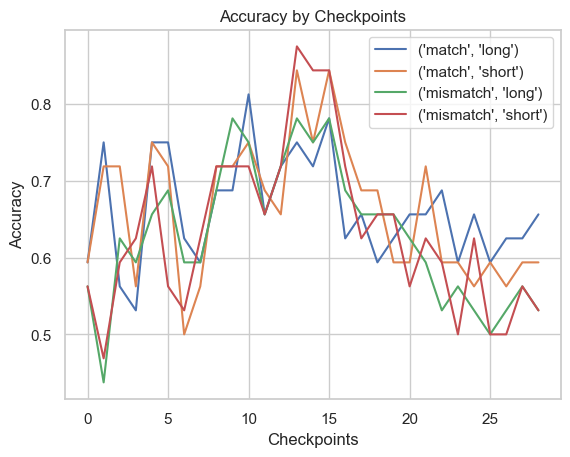

In [8]:
# plot_by_columns(df, col1, col2, title, x_label, y_label, num_of_checkpoints):
plot_by_columns(df,'plural_match','length', 'Accuracy by Checkpoints', 'Checkpoints', 'Accuracy', len(list_of_checkpoints))

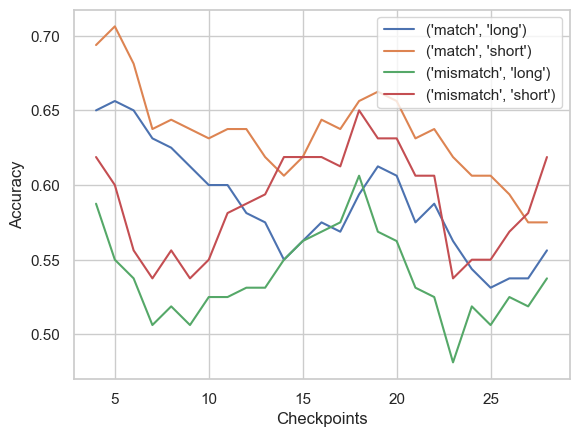

In [15]:
# plot using matplotlib rolling average
import matplotlib.pyplot as plt
import numpy as np
correct_cols = [col for col in df.columns if 'correct' in col]
df_groupby = df.groupby(['plural_match','length'])[correct_cols].mean()
# plot the accuracy by checkpoint for each dependency type and each match type using the df_groupby
steps = np.arange(len(list_of_checkpoints))
plt.plot(steps, df_groupby.iloc[0].rolling(window=5).mean(), label = df_groupby.index[0])
plt.plot(steps, df_groupby.iloc[1].rolling(window=5).mean(), label = df_groupby.index[1])
plt.plot(steps, df_groupby.iloc[2].rolling(window=5).mean(), label = df_groupby.index[2])
plt.plot(steps, df_groupby.iloc[3].rolling(window=5).mean(), label = df_groupby.index[3])
# define axis
plt.xlabel('Checkpoints')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
df.groupby(['dependency', 'match'])["correct"].mean().plot(kind='bar')

In [ ]:
# Calculate accuracy
import numpy as np
accuracy = np.array(df['predicted_token'] == df['label']).mean()

# Print accuracy
print("Accuracy:", accuracy)

In [ ]:
df['correct'] = df['predicted_token'] == df['label']

In [ ]:
df.groupby(['plural_match', 'length'])["correct"].mean()

In [ ]:
# plot the accuracy by length
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")
ax = sns.barplot(x="length", y="correct", hue="plural_match", data=df)
plt.show()

In [ ]:
# plot the accuracy by length
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")
ax = sns.barplot(x="length", y="correct", hue="plural_match", data=df)
plt.show()

In [ ]:
# # from transformers import AutoTokenizer, BertForMaskedLM
# # tokenizer = AutoTokenizer.from_pretrained('google/multiberts-seed_0-step_40k')
# # model = BertForMaskedLM.from_pretrained("google/multiberts-seed_0-step_40k")
# from transformers import AutoTokenizer, BertForMaskedLM
# import torch
#
# tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
# model = BertForMaskedLM.from_pretrained("bert-base-uncased")
#
# text="The tourist hired the guides that the locals angered due to a misunderstanding. Therefore, the locals angered the [MASK]"
# input_label = "guides"
# input_distractor = "tourist"
#
# with torch.no_grad():
#     # Encode the text
#     encoded_input = tokenizer(text, return_tensors='pt')
#     mask_token_index = torch.where(encoded_input['input_ids'] == tokenizer.mask_token_id)[1].item()
#     # mask_token_index = (encoded_input.input_ids == tokenizer.mask_token_id)[0].nonzero(as_tuple=True)[0]
#
#     # Get the label and distractor indices
#     values = [input_label,input_distractor]
#     label_index = tokenizer.encode(input_label, add_special_tokens=False)[0]
#     distractor_index = tokenizer.encode(input_distractor,   add_special_tokens=False)[0]
#     # Predict the masked token
#     output = model(**encoded_input)
#     predictions = output.logits
#     masked_token_predictions = predictions[0, mask_token_index]
#     masked_token_predictions_softmax = torch.softmax(masked_token_predictions, dim=0)
#     masked_token_predictions_softmax_label_distractor = masked_token_predictions_softmax[[label_index,distractor_index]]
#
#     # Get the predicted token index
#     predicted_token_index = torch.argmax(masked_token_predictions_softmax_label_distractor).item()
#     predicted_token = values[predicted_token_index]


In [ ]:
# tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
# model = BertForMaskedLM.from_pretrained("bert-base-uncased")

tokenizer = AutoTokenizer.from_pretrained("google/multiberts-seed_0")
model = BertForMaskedLM.from_pretrained("google/multiberts-seed_0")

# predict the masked token
step = 'pretrained'
pred_col = f'predicted_token{step}'
correct_col = f'correct{step}'

# predict the masked token
df[pred_col] = df.apply(lambda row: predict_masked_token(row), axis=1)
df[correct_col] = df[pred_col] == df['label']

# calculate the accuracy
accuracy = np.array(df[correct_col]).mean()
#df.groupby(['plural_match', 'length'])[correct_col].mean().to_csv(f'accuracy/{checkpoint}.csv')
print('example', accuracy)
# save the accuracy
#accuracies.append(accuracy)

In [ ]:
from transformers import AutoTokenizer, BertForMaskedLM
import torch

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model = BertForMaskedLM.from_pretrained("bert-base-uncased")

inputs = tokenizer("The capital of France is [MASK].", return_tensors="pt")

with torch.no_grad():
    logits = model(**inputs).logits

# retrieve index of [MASK]
mask_token_index = (inputs.input_ids == tokenizer.mask_token_id)[0].nonzero(as_tuple=True)[0]

predicted_token_id = logits[0, mask_token_index].argmax(axis=-1)
tokenizer.decode(predicted_token_id)

labels = tokenizer("The capital of France is Paris.", return_tensors="pt")["input_ids"]
# mask labels of non-[MASK] tokens
labels = torch.where(inputs.input_ids == tokenizer.mask_token_id, labels, -100)

outputs = model(**inputs, labels=labels)
round(outputs.loss.item(), 2)